<a href="https://colab.research.google.com/github/ErenTuksal/phys-ua210/blob/main/unit09_neural/demo2_mnist_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification via a Neural Network

In the the [MNIST SVM example](../svm/mnist_svm.ipynb), we introduced the classic MNIST digit classification problem and trained a simple SVM classifier for the model.  In this demo, we will try a simple neural network.  The network we will create will not perform quite as well -- we will obtain an accuracy of only around 97%, while the SVM classifier obtains an accuracy of over 98%.  However, once we understand these simple neural networks, we will be able to build more sophisticated networks that can obtain much better classification rate.  Also, in doing this demo, you will learn several important features of the `pytorch` package in addition to the concepts shown in the [simple neural network example](./demo1_synthetic.ipynb):

* How to construct multi-class classifiers using categorical cross entropy.
* How to save and load the model after training.  

## Loading PyTorch

We first load the `pytorch` packages as in the [simple neural network example](./demo1_synthetic.ipynb).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

Computations on larger neural networks can be sped up by using a Graphics Processor Unit (GPU).  If you are running on Google colab, you can select a GPU.  Several instructions are available online, for example, you can follow [this short tutorial on Medium](https://medium.com/@208r1a6734/how-to-connect-the-gpu-in-google-colab-5ff4cbd4b0a1).  The Google colab GPU is not very powerful, and the MNIST is not a large network so the speed up from using a GPU may not be that significant.

You can see if you have activated a GPU with the following command.


In [2]:
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
else:
  print("No GPU available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Tesla T4


We also load some other common packages.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Next, we download the data.  The first time you run this code, it will load the data into directory `../data`.  The downloader has a transform that sets the mean to `0.1307` and `0.3081`, which are the mean and std deviation in the MNIST data set in the way it is stored in the raw data.

In [4]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])

# Download and load the training data
train_data = datasets.MNIST('../data', train=True, download=True, transform=transform)

# Download and load the test data
test_data = datasets.MNIST('../data', train=False, download=True, transform=transform)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.59MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.39MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



We will also use the `plt_digit` function from the [MNIST SVM example](../svm/mnist_svm.ipynb) to display digits.

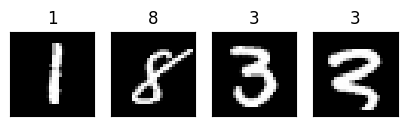

In [5]:
def plt_digit(ax, x):
    nrow = 28
    ncol = 28
    xsq = x.reshape((nrow,ncol))
    ax.imshow(xsq,  cmap='Greys_r')
    ax.set_xticks([])
    ax.set_yticks([])

# Select random digits
nplt = 4
nsamp = len(train_data)
Iperm = np.random.permutation(nsamp)

# Plot the images using the subplot command
fig, ax = plt.subplots(1,nplt, figsize=(5,10))
for i in range(nplt):
    ind = Iperm[i]

    # Get the data from the training data set
    x, y = train_data[ind]
    x = x.numpy()

    # Plot the image
    plt_digit(ax[i], x)
    ax[i].set_title(y)

## Creating a Simple Neural Network.

Now we create a very simple network.  The features are:
*  We have one hidden layer with `nh=100` units.  
*  One output layer with `nout=10` units, one for each of the 10 possible classes
*  The output activation is `softmax`, which is used for multi-class targets

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, nin, nh, nout):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(nin, nh)
        self.fc2 = nn.Linear(nh, nout)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x # Apply softmax to the output

nin = 28*28
nh = 100
nout = 10
model = Net(nin, nh, nout)


We print the model summary.

In [7]:
print(model)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


Epoch 1/30, Train Accuracy: 78.97%, Test Accuracy: 91.38%
Epoch 2/30, Train Accuracy: 92.92%, Test Accuracy: 93.96%
Epoch 3/30, Train Accuracy: 94.64%, Test Accuracy: 94.59%
Epoch 4/30, Train Accuracy: 95.49%, Test Accuracy: 95.40%
Epoch 5/30, Train Accuracy: 96.10%, Test Accuracy: 95.53%
Epoch 6/30, Train Accuracy: 96.55%, Test Accuracy: 96.12%
Epoch 7/30, Train Accuracy: 97.02%, Test Accuracy: 96.23%
Epoch 8/30, Train Accuracy: 97.35%, Test Accuracy: 96.28%
Epoch 9/30, Train Accuracy: 97.65%, Test Accuracy: 96.51%
Epoch 10/30, Train Accuracy: 97.89%, Test Accuracy: 96.56%
Epoch 11/30, Train Accuracy: 98.10%, Test Accuracy: 96.74%
Epoch 12/30, Train Accuracy: 98.22%, Test Accuracy: 96.72%
Epoch 13/30, Train Accuracy: 98.37%, Test Accuracy: 97.03%
Epoch 14/30, Train Accuracy: 98.53%, Test Accuracy: 97.05%
Epoch 15/30, Train Accuracy: 98.62%, Test Accuracy: 97.01%
Epoch 16/30, Train Accuracy: 98.67%, Test Accuracy: 96.97%
Epoch 17/30, Train Accuracy: 98.75%, Test Accuracy: 97.08%
Epoch 

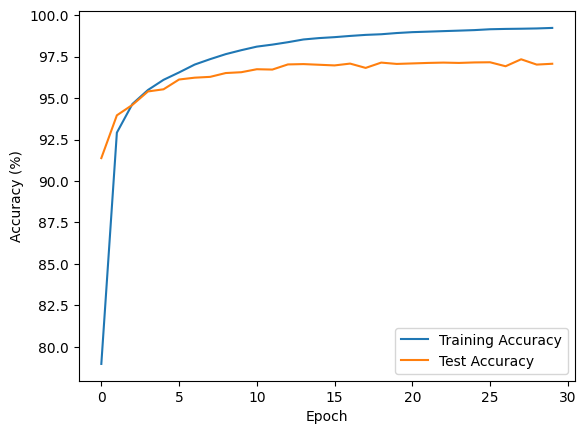

In [8]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training settings
batch_size = 100
epochs = 30

# Data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Lists to store training and testing accuracy for each epoch
train_accuracy_history = []
test_accuracy_history = []


# Training loop
for epoch in range(epochs):
    # Training
    model.train()
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_accuracy = 100 * correct / total
    train_accuracy_history.append(train_accuracy)

    # Testing
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    test_accuracy = 100 * correct / total
    test_accuracy_history.append(test_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

print("Finished Training")

#Plot the accuracy
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(test_accuracy_history, label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

## Saving and Loading the model

Since the training takes a long time, it is useful to save the results.  


In [ ]:
# prompt: Write code to save the trained model to a file

torch.save(model, 'mnist_model.pth')


In [ ]:

model1 = torch.load('mnist_model.pth')
print(model1)


NameError: name 'torch' is not defined